## Graphene Pore
### In this workflow, we will use the `GraphenePore` recipe in mBuild to initialize a system of water and graphene slit pores.

In [1]:
import mbuild as mb
import matplotlib.pyplot as plt
import numpy as np
from foyer import Forcefield
from calc_numberdensity import calc_number_density

#### Load in a water molecule as a mBuild `Compound`

In [2]:
water = mb.load('files/tip3p.mol2')
water.name = 'SOL'

/Users/raymatsumoto/anaconda3/envs/mosdef36/lib/python3.6/site-packages/mdtraj/formats/mol2.py:203: FutureWarning: read_table is deprecated, use read_csv instead.
  index_col=0, header=None, sep="\s+", engine='python')


#### Load in a separate `Forcefield` object for the graphene and water

In [3]:
c_ff = Forcefield('files/carbon.xml')
spce = Forcefield('files/spce.xml')

#### Importing Graphene Pores
To run this notebook, you will have to clone the pore-builder repository from GitHub: https://github.com/rmatsum836/Pore-Builder

In [4]:
try:
    GraphenePoreSolvent = mb.recipes.GraphenePoreSolvent
except (ImportError, AttributeError):
    try:
        import porebuilder
        GraphenePoreSolvent = porebuilder.porebuilder.GraphenePoreSolvent
    except ImportError:
        pass

#### Initialize system
Here we will call `GraphenePoreSolvent` to initialize a system with two graphene slit pores and 600 water molecules

In [5]:
system = GraphenePoreSolvent(pore_depth=2,side_dim=2,
                    n_sheets=3,pore_width=1.2,x_bulk=1.5,
                    solvent=water,n_solvent=600)
box = mb.Box(system.periodicity)

/Users/raymatsumoto/mbuild/mbuild/lattice.py:578: UserWarning: Periodicity of non-rectangular lattices are not valid with default boxes. Only rectangular lattices are valid at this time.
  warn('Periodicity of non-rectangular lattices are not valid with '


#### Separate molecules into different compounds
Because we are going to apply multiple force fields, we need to separate the waters and graphene into separate mBuild compounds.  Calling `apply` will apply the forcefield to the compounds and convert them to parametrized ParmEd `Structures`

In [6]:
water = mb.Compound()
graphene = mb.Compound()
for child in system.children:
    if child.name == 'SOL':
        water.add(mb.clone(child))
    else:
        graphene.add(mb.clone(child))

water_pmd = spce.apply(water, residues='SOL')           
pore_pmd = c_ff.apply(graphene)

/Users/raymatsumoto/anaconda3/envs/mosdef36/lib/python3.6/site-packages/parmed/openmm/topsystem.py:238: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  'all be present in one form or another.', OpenMMWarning)


#### Now we will combine the two paramterezed ParmEd structures and save them as `gro` and `top` files

In [7]:
system = water_pmd + pore_pmd
system.box[:3] = box.maxs * 10.0
system.save('init.gro', overwrite=True, combine='all')
system.save('init.top', overwrite=True, combine='all')

#### Now we can run a short simulation of our system
We will first call `gmx grompp` to compile the input file for the simulation, and then call `gmx mdrun` to actually run the simulation.

In [8]:
!gmx grompp -f files/nvt.mdp -c init.gro -p init.top -o nvt.tpr

                  :-) GROMACS - gmx grompp, VERSION 5.1.2 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
 Dimitrios Karkoulis    Peter Kasson        Jiri Kraus      Carsten Kutzner  
    Per Larsson      Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff 
   Erik Marklund      Teemu Murtola       Szilard Pall       Sander Pronk   
   Roland Schulz     Alexey Shvetsov     Michael Shirts     Alfons Sijbers  
   Peter Tieleman    Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University

In [9]:
!gmx mdrun -v -deffnm nvt

                   :-) GROMACS - gmx mdrun, VERSION 5.1.2 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov  Herman J.C. Berendsen    Par Bjelkmar   
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra   Sebastian Fritsch 
  Gerrit Groenhof   Christoph Junghans   Anca Hamuraru    Vincent Hindriksen
 Dimitrios Karkoulis    Peter Kasson        Jiri Kraus      Carsten Kutzner  
    Per Larsson      Justin A. Lemkul   Magnus Lundborg   Pieter Meulenhoff 
   Erik Marklund      Teemu Murtola       Szilard Pall       Sander Pronk   
   Roland Schulz     Alexey Shvetsov     Michael Shirts     Alfons Sijbers  
   Peter Tieleman    Teemu Virolainen  Christian Wennberg    Maarten Wolf   
                           and the project leaders:
        Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2015, The GROMACS development team at
Uppsala University

step 40900, remaining wall clock time:    70 s          vol 0.81  imb F  1% l 0.92  imb F  4% vol 0.92  imb F  3% vol 0.91  imb F  6% vol 0.90  imb F  6% vol 0.89  imb F  1% vol 0.89  imb F  5% vol 0.88  imb F  3% vol 0.88  imb F  1% vol 0.85  imb F  2% vol 0.87  imb F  1% vol 0.87  imb F  1% vol 0.88  imb F  4% vol 0.85  imb F 11% vol 0.85  imb F  3% vol 0.81  imb F  1% vol 0.82  imb F  5% vol 0.80  imb F  2% vol 0.80  imb F  1% vol 0.81  imb F  1% vol 0.81  imb F  1% vol 0.81  imb F  2% vol 0.84  imb F  2% vol 0.84  imb F  2% vol 0.86  imb F  5% vol 0.84  imb F  5% vol 0.86  imb F  1% vol 0.85  imb F  2% vol 0.85  imb F  3% vol 0.83  imb F  2% vol 0.83  imb F  3% vol 0.85  imb F  2% vol 0.83  imb F  2% vol 0.84  imb F  2% vol 0.83  imb F  6% vol 0.81  imb F  3% vol 0.82  imb F  2% vol 0.81  imb F  2% vol 0.82  imb F  7% vol 0.83  imb F 26% vol 0.83  imb F  9% vol 0.85  imb F  7% vol 0.83  imb F 10% vol 0.84  imb F  5% vol 0.85  imb F  2% vol 0.88  imb F  5% vol 0.88  imb F  2% vol 0.

step 81700, remaining wall clock time:    21 s          vol 0.86  imb F  3% vol 0.89  imb F  3% vol 0.87  imb F  4% vol 0.85  imb F  1% vol 0.85  imb F  2% vol 0.83  imb F  2% vol 0.85  imb F  2% vol 0.86  imb F  3% vol 0.84  imb F  1% vol 0.84  imb F  1% vol 0.83  imb F  1% vol 0.85  imb F  2% vol 0.86  imb F  2% vol 0.85  imb F  1% vol 0.84  imb F  1% vol 0.82  imb F  1% vol 0.81  imb F  2% vol 0.83  imb F  1% vol 0.83  imb F  2% vol 0.84  imb F  2% vol 0.84  imb F  2% vol 0.85  imb F  2% vol 0.84  imb F  2% vol 0.84  imb F  1% vol 0.85  imb F  1% vol 0.85  imb F  1% vol 0.86  imb F  0% vol 0.89  imb F  1% vol 0.89  imb F  4% vol 0.86  imb F  2% vol 0.84  imb F  0% vol 0.84  imb F  1% vol 0.83  imb F  1% vol 0.83  imb F  1% vol 0.82  imb F  2% vol 0.82  imb F  3% vol 0.81  imb F  2% vol 0.82  imb F  1% vol 0.80  imb F  2% vol 0.82  imb F  2% vol 0.83  imb F  2% vol 0.85  imb F  2% vol 0.85  imb F  1% vol 0.88  imb F  4% vol 0.89  imb F  2% vol 0.88  imb F  1% vol 0.87  imb F  2% vol 

step 99900, remaining wall clock time:     0 s          vol 0.82  imb F  3% vol 0.82  imb F  2% vol 0.82  imb F  2% vol 0.82  imb F  3% vol 0.82  imb F  1% vol 0.84  imb F  5% vol 0.84  imb F  4% vol 0.86  imb F  3% vol 0.88  imb F  6% vol 0.91  imb F  3% vol 0.87  imb F  3% vol 0.87  imb F  1% vol 0.85  imb F  1% vol 0.85  imb F  1% vol 0.84  imb F  3% vol 0.84  imb F  3% vol 0.87  imb F  3% vol 0.86  imb F  1% vol 0.86  imb F  3% vol 0.88  imb F  2% vol 0.88  imb F  2% vol 0.90  imb F  4% vol 0.89  imb F  2% vol 0.88  imb F  1% vol 0.88  imb F  1% vol 0.87  imb F  1% vol 0.86  imb F  2% vol 0.85  imb F  1% vol 0.86  imb F  2% vol 0.86  imb F  2% vol 0.85  imb F  2% vol 0.86  imb F  2% vol 0.85  imb F  2% vol 0.85  imb F  2% vol 0.86  imb F  2% vol 0.86  imb F  2% vol 0.88  imb F  5% vol 0.91  imb F  1% vol 0.90  imb F  1% vol 0.90  imb F  2% vol 0.90  imb F  2% vol 0.90  imb F  3% vol 0.85  imb F  2% vol 0.85  imb F  1% vol 0.84  imb F  1% vol 0.86  imb F  2% vol 0.87  imb F  3% vol 

In [10]:
# Load in reference data to compare to
reference_num_den = np.loadtxt('ref_data/numden.txt')

In [11]:
gro_file = 'nvt.gro'
trj_file = 'nvt.trr'
top_file = 'init.top'

In [12]:
# Set dimensions of system for calculation of number density profiles
box_range = [0.838, 2.038]
mins = [1.684, 0, 0]
maxs = [3.403, 0, 0]
area = 3.78

#### Plotting Number density
Using `calc_number_density` we can calculate and plot the number density profile of water in the slit pores.  From the results, we observe that the waters mainly exist at the walls of the slit pore at ~1.2 nm and ~1.8 nm respectively.

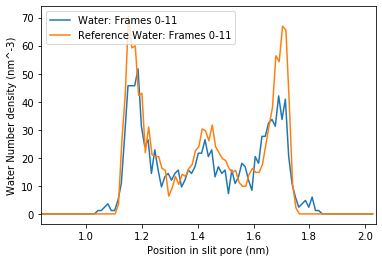

In [13]:
plt.figure()
plt.xlim(box_range[0], box_range[1])
rho, bins = calc_number_density(gro_file, trj_file, top_file, area, dim=1,
                                    box_range=box_range, n_bins=100, frame_range=range(0,11),
                                    maxs=maxs, mins=mins)
plt.plot(bins, rho[0], label='Water: Frames {}-{}'.format(0,11))
plt.plot(reference_num_den[:,0], reference_num_den[:,1], label='Reference Water: Frames {}-{}'.format(0,11))
plt.legend()
plt.ylabel('Water Number density (nm^-3)')
plt.xlabel('Position in slit pore (nm)')
plt.savefig('number-density.pdf')